In [1]:
!pip install --upgrade pip
!pip install pillow
!pip install scipy
#from PIL import Image
!pip install keras-tuner
!pip install pandas
!pip install scikit-learn

In [2]:
!apt install libgl1-mesa-glx -y
import cv2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


ModuleNotFoundError: No module named 'cv2'

In [11]:
# First train
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from sklearn.utils import class_weight
import numpy as np
import datetime

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import *
import tensorflow as tf 


#import tensorflow_addons as tfa
# dimensions of our images.

#import imgaug.augmenters as img_aug

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.applications import DenseNet121,ResNet152V2,InceptionResNetV2
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import apply_affine_transform

def recall_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_metric(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def get_train_image_quant(directory):
    datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator()
    data = datagen.flow_from_directory(directory)
    unique = np.unique(data.classes, return_counts=True)
    labels_dict = dict(zip(unique[0], unique[1]))
    print(labels_dict)
    image_quant_per_class = []
    for key in labels_dict:
        for i in range(labels_dict[key]):
            image_quant_per_class.append(key)
    return image_quant_per_class

def get_class_weights(labels, one_hot=False):
        if one_hot is False:
            n_classes = max(labels) + 1
        else:
            n_classes = len(labels[0])
        class_counts = [0 for _ in range(int(n_classes))]
        if one_hot is False:
            for label in labels:
                class_counts[label] += 1
        else:
            for label in labels:
                class_counts[label.index(1)] += 1
        return {i : (1. / class_counts[i]) * float(len(labels)) / float(n_classes) for i in range(int(n_classes))}






def add_noise(img):
    #print(img.shape)
    #seq = img_aug.Sequential([
    #img_aug.Emboss(alpha=(0.2, 0.2), strength=(1.5, 1.5))])
  #  cv2_imshow(img)
    angle = random.choice([0, 90, 180, 270])
    if angle != 0:
        img = apply_affine_transform(img, theta=angle, fill_mode='nearest')
    return img
    


def first_train(train_dir,val_dir,path_to_model):
    img_width, img_height = 400, 400

    train_data_dir = train_dir
    validation_data_dir = val_dir

    train_images_labels = get_train_image_quant(train_data_dir) # for weights balancing
    print (get_class_weights(train_images_labels))


    nb_train_samples = len(os.listdir(train_dir+"/clean/")) + len(os.listdir(train_dir+"/with_carotid/"))
    nb_validation_samples = len(os.listdir(val_dir+"/clean/")) + len(os.listdir(val_dir+"/with_carotid/"))

    epochs = 50
    batch_size = 16

    #path_to_model = "gdrive/MyDrive/data_sets/panoramic/panoramic_firsttrain.h5"

    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    train_datagen = ImageDataGenerator(
        # horizontal_flip=True,
        # vertical_flip=True,
         rescale=1. / 255,
      #   preprocessing_function=add_noise,
         width_shift_range=[0,40], 
         zoom_range=[0.9,1.1],
          rotation_range=15,
          shear_range=0.1,
           fill_mode='constant', cval=0
           
    )

# this is the augmentation configuration we will use for testing:
# only rescaling
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')







    # top layer
    base_model = InceptionResNetV2(
            weights='imagenet',  # Load weights pre-trained on ImageNet.
            input_shape=input_shape,
            include_top=False)  # Do not include the ImageNet classifier at the top.
    base_model.trainable = False

    # top layer
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    #auc = tf.keras.metrics.AUC(name='auc')
    #auc = tfa.metrics.F1Score(num_classes=2,name='f1')
    opt = Adam(learning_rate=0.0001)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy',f1_metric])

    print(model.summary())



    early = EarlyStopping(monitor='val_f1_metric', min_delta=0.01, \
        patience=10, verbose=1, mode='max')

    checkpoint = ModelCheckpoint(path_to_model, monitor='val_f1_metric',verbose=1,   # val_recall_metric
                                    save_best_only=True, save_weights_only=False, mode='max', save_freq='epoch')

    #log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,  histogram_freq=1, write_graph=True, write_images=True) 

 # 'val_accuracy'
    histroy = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=300,#epochs,
    verbose=1,
    callbacks=[ early,checkpoint],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples//batch_size,
    class_weight=get_class_weights(train_images_labels)
    ) 
    
    return histroy

In [4]:
# fine tuning - Second train
import datetime
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight
import numpy as np

def get_train_image_quant(directory):
    datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator()
    data = datagen.flow_from_directory(directory)
    unique = np.unique(data.classes, return_counts=True)
    labels_dict = dict(zip(unique[0], unique[1]))
    print(labels_dict)
    image_quant_per_class = []
    for key in labels_dict:
        for i in range(labels_dict[key]):
            image_quant_per_class.append(key)
    return image_quant_per_class

def get_class_weights(labels, one_hot=False):
        if one_hot is False:
            n_classes = max(labels) + 1
        else:
            n_classes = len(labels[0])
        class_counts = [0 for _ in range(int(n_classes))]
        if one_hot is False:
            for label in labels:
                class_counts[label] += 1
        else:
            for label in labels:
                class_counts[label.index(1)] += 1
        return {i : (1. / class_counts[i]) * float(len(labels)) / float(n_classes) for i in range(int(n_classes))}

def fine_tuning_train(train_dir,val_dir,previous_model_path, current_model_path):
    img_width, img_height = 400, 400

    train_data_dir = train_dir
    validation_data_dir = val_dir

    train_images_labels = get_train_image_quant(train_data_dir) # for weights balancing
    print (get_class_weights(train_images_labels))


    nb_train_samples = len(os.listdir(train_dir+"/clean/")) + len(os.listdir(train_dir+"/with_carotid/"))
    nb_validation_samples = len(os.listdir(val_dir+"/clean/")) + len(os.listdir(val_dir+"/with_carotid/"))

    epochs = 50
    batch_size = 12

     

    train_images_labels = get_train_image_quant(train_data_dir) # for weights balancing
    print (get_class_weights(train_images_labels))


#layer_to_train = 3
#for layer in model.layers[:layer_to_train]:
#        if not isinstance(layer, BatchNormalization):
#            layer.trainable = True  

    dependencies = {
            'recall_metric': recall_metric,
            "f1_metric": f1_metric
        }

    model = load_model(previous_model_path, custom_objects=dependencies)


    model.trainable = True
    #model.layers[-3:].trainable = True

    opt =  tensorflow.keras.optimizers.Adam(1e-6)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy',f1_metric])


    print(model.summary())

    train_datagen = ImageDataGenerator(
        # horizontal_flip=True,
        # vertical_flip=True,
         rescale=1. / 255,
      #   preprocessing_function=add_noise,
         width_shift_range=[0,40], 
         zoom_range=[0.9,1.1],
          rotation_range=15,
          shear_range=0.1,
           fill_mode='constant', cval=0
           
    )

# this is the augmentation configuration we will use for testing:
# only rescaling
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')



    early = EarlyStopping(monitor='val_loss', min_delta=0.0001, \
        patience=25, verbose=1, mode='auto')

    checkpoint = ModelCheckpoint(current_model_path, monitor='val_accuracy',verbose=1,   # val_recall_metric
                                    save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,  histogram_freq=1, write_graph=True, write_images=True) 

#class_weights = dict(zip(np.unique(train_generator.classes), class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes))) 




    histroy = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=300,#epochs,
    verbose=1,
    callbacks=[ early,checkpoint],
    validation_data=validation_generator,
    validation_steps=nb_validation_samples//batch_size,
    class_weight=get_class_weights(train_images_labels)
    )  
    
    return histroy

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.imagenet_utils import decode_predictions
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import load_model
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score

def recall_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tensorflow.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tensorflow.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tensorflow.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

#map grad overly
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


def prepare_img(img, img_width, img_height,channels):
    img = img_to_array(img)
    img = img.reshape(1, img_width, img_height, channels).astype('float32')
    img = img / 255.0
    return img

def calc_results_onTest(Testpath,modelPath,fold_num):
    channels =3
    img_width, img_height = 400, 400



    dependencies = {
            'recall_metric': recall_metric,
            "f1_metric": f1_metric
        }

    model = load_model(modelPath, custom_objects=dependencies)

    model1 = model

# Remove last layer's softmax
    #model1.layers[-1].activation = None

# Print what the top predicted class is

#print("Predicted:", decode_predictions(preds, top=1)[0])
# Generate class activation heatmap
    path = Testpath

    y_preds,y_true = [],[]
    for class_type in ["with_carotid/","clean/"]:
      file_list = os.listdir(path+class_type)


  
      counter=0
      for filename in file_list:
    #print("open",filename )
        counter+=1
        img = load_img(path+class_type+filename, grayscale=False, target_size=(img_width, img_height))
    #plt.matshow(img)
    #plt.show()
        img = prepare_img(img,img_width, img_height,channels)
        preds = model1.predict(img)
        print(counter," ", filename,np.argmax(preds))
        y_preds.append(np.argmax(preds))
        if "with_carotid" in class_type:y_true.append(1)
        else: y_true.append(0)
    #heatmap = make_gradcam_heatmap(img, model1.get_layer('densenet121'), 'conv5_block16_concat',1)

# Display heatmap
    #plt.matshow(heatmap)
    #plt.show()

    #save_and_display_gradcam(path+class_type+filename, heatmap)
    if os.path.exists("output_CV_01.txt"):
        f=open("output_CV_01.txt", 'a')
    else:
        f=open("output_CV_01.txt", 'w+')
    



    f.write("\n")
    f.write("---------------------"+str(fold_num)+"---------------------"+"\n")
    f.write("y_preds: "+ str(y_preds)+"\n")
    f.write("y_true" + str(y_true)+"\n")

    f.write("recall: " + str(recall_score(y_true, y_preds))+"\n")
    f.write("precision: "+ str(precision_score(y_true, y_preds))+"\n")
    f.write("F1: "+ str(f1_score(y_true, y_preds))+"\n")
    f.write("accuracy: "+ str(accuracy_score(y_true, y_preds))+"\n")
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    specificity = tn / (tn+fp)
    f.write("specificity: " +str(specificity)+"\n")
    f.write("confusion: "+"\n")
    f.write(str(confusion_matrix(y_true, y_preds))+"\n")
    f.write("------------------------------------------"+"\n")
    f.write("\n")
    f.close()
    return



6
panoram/CV_7/fold_6/train/
panoram/CV_7/fold_6/val/
Found 371 images belonging to 2 classes.
{0: 240, 1: 131}
{0: 0.7729166666666667, 1: 1.416030534351145}
Found 371 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
29097984/29084464 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 12, 12, 1024)      7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              150995968 
_________________________________________________________________
dropout_2 (Dropout

Found 144 images belonging to 2 classes.
Epoch 1/300
30/30 [==============================] - 44s 1s/step - loss: 0.2915 - accuracy: 0.9053 - f1_metric: 0.9053 - val_loss: 0.4686 - val_accuracy: 0.8194 - val_f1_metric: 0.8194

Epoch 00001: val_accuracy improved from -inf to 0.81944, saving model to panoram/CV_7/CV7_6.h5
Epoch 2/300
30/30 [==============================] - 36s 1s/step - loss: 0.2237 - accuracy: 0.9164 - f1_metric: 0.9167 - val_loss: 0.4461 - val_accuracy: 0.8264 - val_f1_metric: 0.8264

Epoch 00002: val_accuracy improved from 0.81944 to 0.82639, saving model to panoram/CV_7/CV7_6.h5
Epoch 3/300
30/30 [==============================] - 35s 1s/step - loss: 0.2652 - accuracy: 0.9053 - f1_metric: 0.9053 - val_loss: 0.4641 - val_accuracy: 0.8125 - val_f1_metric: 0.8125

Epoch 00003: val_accuracy did not improve from 0.82639
Epoch 4/300
30/30 [==============================] - 35s 1s/step - loss: 0.2198 - accuracy: 0.9359 - f1_metric: 0.9359 - val_loss: 0.3563 - val_accuracy:

30/30 [==============================] - 34s 1s/step - loss: 0.0283 - accuracy: 0.9944 - f1_metric: 0.9944 - val_loss: 0.3164 - val_accuracy: 0.8750 - val_f1_metric: 0.8750

Epoch 00067: val_accuracy did not improve from 0.90278
Epoch 68/300
30/30 [==============================] - 37s 1s/step - loss: 0.0450 - accuracy: 0.9833 - f1_metric: 0.9833 - val_loss: 0.3301 - val_accuracy: 0.8750 - val_f1_metric: 0.8750

Epoch 00068: val_accuracy did not improve from 0.90278
Epoch 69/300
30/30 [==============================] - 40s 1s/step - loss: 0.0428 - accuracy: 0.9889 - f1_metric: 0.9889 - val_loss: 0.3406 - val_accuracy: 0.8750 - val_f1_metric: 0.8750

Epoch 00069: val_accuracy did not improve from 0.90278
Epoch 70/300
30/30 [==============================] - 37s 1s/step - loss: 0.0177 - accuracy: 0.9972 - f1_metric: 0.9972 - val_loss: 0.3628 - val_accuracy: 0.8750 - val_f1_metric: 0.8750

Epoch 00070: val_accuracy did not improve from 0.90278
Epoch 71/300
30/30 [=========================

79   R_10685278.png 0
80   R_10692258.png 0
81   R_10700933.png 0
82   R_10702026.png 0
83   R_10711028.png 0
84   R_10712338.png 1
85   R_10713082.png 0
86   R_10713758.png 0
87   R_10717739.png 0
88   R_10718593.png 0
89   R_10721321.png 0
90   R_10730621.png 0
91   R_10731260.png 0
92   R_10733594.png 0
93   R_10738623.png 0
94   R_10739019.png 0
95   R_10740505.png 0
96   R_10740869.png 0
97   R_10742129.png 1
98   R_10742550.png 1
99   R_10743160.png 0
100   R_10745624.png 0
101   R_10747408.png 0
102   R_10749294.png 0
103   R_10753040.png 0
104   R_10754108.png 0
105   R_10754881.png 0
106   R_10754994.png 0
107   R_10755080.png 0
108   R_10757983.png 0
109   R_10758458.png 0
110   R_10762505.png 0
111   R_1155314309.png 0
112   R_1226075450.png 0
113   R_1507814069.png 0
114   R_1874919220.png 0
115   R_1892867010.png 1
116   R_2207064839.png 0
117   R_2352437653.png 1
118   R_3036417066.png 0
119   R_3333657940.png 0
120   R_4198855688.png 0


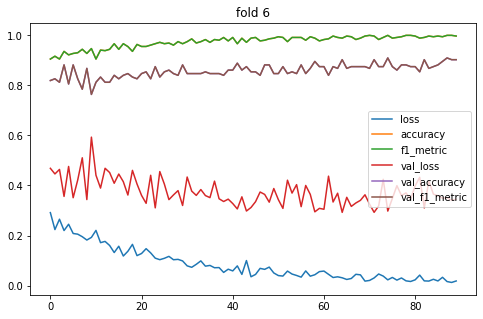

<Figure size 432x288 with 0 Axes>

In [12]:
for i in range(6,7):
    print(str(i))
    train = "panoram/CV_7/fold_"+str(i)+"/train/"
    val =   "panoram/CV_7/fold_"+str(i)+"/val/"
    print(train)
    print(val)
    history1 = first_train(train,val, path_to_model="panoram/CV_7/CV7_"+str(i) +".h5")
    print("--------------------------------END FIRST TRAIN fold:"+str(i)+" ----------------------------------------------")
    history2 = fine_tuning_train(train,val, previous_model_path = "panoram/CV_7/CV7_"+str(i) +".h5", current_model_path = "panoram/CV_7/CV7_"+str(i) +".h5" )
    print("--------------------------------END SECOND fold:"+str(i)+" ----------------------------------------------")
    
    calc_results_onTest(Testpath="panoram/CV_7/fold_"+str(i)+"/test/",modelPath="panoram/CV_7/CV7_"+str(i) +".h5",fold_num=i)
    
    import pandas as pd
    pd.DataFrame(history2.history).plot(figsize=(8,5))
    plt.title("fold "+str(i))
    plt.show()
    plt.savefig("history"+str(i)+".png")
    

In [7]:
os.chdir("..")
!pwd

/tf


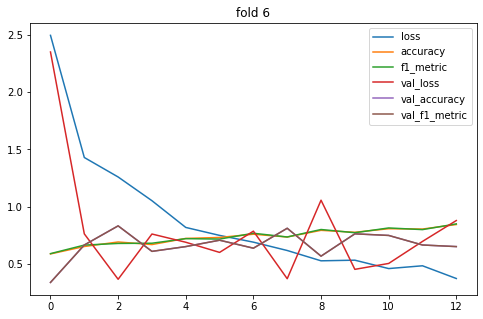

<Figure size 432x288 with 0 Axes>

In [9]:
import pandas as pd
pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.title("fold "+str(i))
plt.show()
plt.savefig("history"+str(i)+".png")

In [ ]:
!pip install pillow
!pip install scipy

#!pip install keras-tuner
!pip install pandas
!pip install scikit-learn
!pip install opencv-python

In [ ]:
#print(os.path.exists("./CV_output.txt"))
f=open("output_CV.txt", "r")
for l in f:
  print(l)
f.close()